In [1]:
from typing import Tuple, Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tqdm.notebook import tqdm

CONTROLLER_ADDR = '192.168.0.104'

df_X = pd.read_csv('X_test.csv', header=None)

In [2]:
def predict(x: Iterable) -> Tuple[float, float, float, float]:
    resp = requests.get(f'http://{CONTROLLER_ADDR}/predict', params={
        f'x{idx + 1}': xi
        for idx, xi in enumerate(x)
    })
    resp.raise_for_status()

    # noinspection PyTypeChecker
    return tuple(float(y) for idx, y in enumerate(str(resp.text).split(' ')) if idx < 4)


predict((-0.52109855, -0.57133687, -0.481523, -0.5882358, -0.80570453, -0.03607523,
         -0.8392386, -0.8549552, 0.3732829, -0.5899839, 0.38921237, 0.5864193,
         1.0258859, -0.41387412, -0.5701152, -0.6521362, -0.8420634, -0.68346435,
         -0.8151803, -0.668313, 0.6052867, 1.0809759, 0.77627265, -0.77486044,))

(0.14, 0.66, 0.15, 0.05)

In [3]:
y_pred = np.array([
    predict(x)
    for _, x in tqdm(df_X.iterrows(), total=len(df_X))
], dtype='float64')

  0%|          | 0/33 [00:00<?, ?it/s]

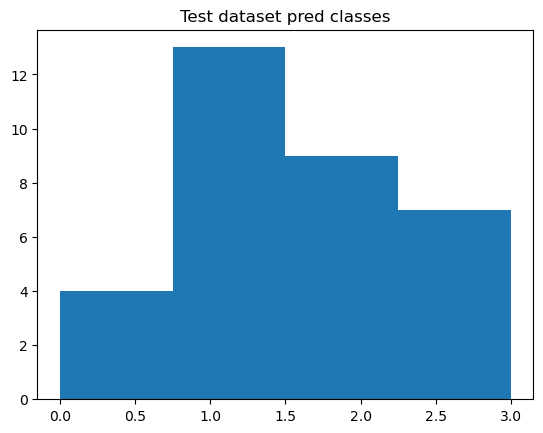

In [4]:
y_pred_cls = np.argmax(y_pred, axis=-1).astype('int32')
plt.title("Test dataset pred classes")
plt.hist(y_pred_cls, bins=4, range=(0, 3))
plt.show()

### Eval on Arduino

In [5]:
df_Y = pd.read_csv('Y_test.csv', header=None)
X_test = df_X.to_numpy(dtype='int32')
y_test = df_Y.to_numpy(dtype='int32').reshape((-1,))

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred_cls)
print(f'Accuracy: {accuracy:.2f}')

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cls))
print("Classification Report:")
print(classification_report(y_test, y_pred_cls, zero_division=0))

Accuracy: 0.85
Confusion Matrix:
[[4 4 0 0]
 [0 8 0 0]
 [0 1 9 0]
 [0 0 0 7]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.62      1.00      0.76         8
           2       1.00      0.90      0.95        10
           3       1.00      1.00      1.00         7

    accuracy                           0.85        33
   macro avg       0.90      0.85      0.84        33
weighted avg       0.91      0.85      0.85        33



### Eval on local machine

In [7]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_local(x):
    input_data = x.reshape(input_details[0]['shape']).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output_data)

y_pred_cls_local = np.array([
    predict_local(X_test[i])
    for i in tqdm(range(len(X_test)), total=len(X_test))
], dtype='int32')

  0%|          | 0/33 [00:00<?, ?it/s]

In [8]:
accuracy = accuracy_score(y_test, y_pred_cls_local)
print(f'Accuracy: {accuracy:.2f}')

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cls_local))
print("Classification Report:")
print(classification_report(y_test, y_pred_cls_local, zero_division=0))

Accuracy: 0.79
Confusion Matrix:
[[6 2 0 0]
 [1 6 1 0]
 [1 0 9 0]
 [0 0 2 5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.75      0.75      0.75         8
           2       0.75      0.90      0.82        10
           3       1.00      0.71      0.83         7

    accuracy                           0.79        33
   macro avg       0.81      0.78      0.79        33
weighted avg       0.80      0.79      0.79        33

